# GGG基盤上の薄膜
検出距離依存性についての調査

| wavelength(nm) | FR(deg.)     | E(deg.)     |
|----------------|--------------|-------------|
| 532            | -2.104965093 | 0.978522465 |


In [1]:
#------------------------
# Google Colab上でのみ実行
#------------------------
import time
%env TOKEN=*************************************
! git clone https://$$TOKEN@github.com/konnitiha3/MOD2NN.git

import sys
sys.path.append('/content/MOD2NN')

from google.colab import drive
drive.mount('/content/drive')

!pip install GPyOpt

env: TOKEN=*************************************
Cloning into 'MOD2NN'...
remote: Enumerating objects: 1049, done.
remote: Counting objects: 100% (220/220), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 1049 (delta 96), reused 164 (delta 64), pack-reused 829
Receiving objects: 100% (1049/1049), 36.34 MiB | 9.01 MiB/s, done.
Resolving deltas: 100% (575/575), done.
Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 4.3 MB/s 
     |████████████████████████████████| 959 kB 29.2 MB/s 
     |████████████████████████████████| 71 kB 10.0 MB/s 
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-py3-none-any.whl size=83609 sha256=4ce24ffef8233a59e7fa2d0a40a772390b70c6de2b6efa6df5dd4c6cee44e5f7
  Stored in directory: /root/.cache/pip/wheels/e6/fa/d1/f9652b5af79f769a0ab74dbead7c7aea9a93c6bc74543fd3ec
  Created wheel for GPy: filename=GPy-1.10.0-cp37-cp37m-

In [2]:
import time
import os
import json
import sys
import re
import glob
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import GPyOpt

from Faraday.two_dim.module.lib.layers import *
from Faraday.two_dim.module.lib import regularizer

tf.random.set_seed(1)

print("TensorFlow:", tf.__version__)
print("Python:", sys.version)

plt.rcParams['font.size'] = 18

TensorFlow: 2.8.2
Python: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]


In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
#@title デフォルトのタイトル テキスト
wavelength = 532.0e-9 #@param {type:"number"}
d = 1.0e-6 #@param {type:"number"}
n = 1.5 #@param {type:"number"}

In [5]:
def create_model(**kwargs):
    shape = (100, 100)
    inputs = tf.keras.Input((28, 28))
    theta = -2.105 * np.pi / 180
    eta = np.arctan(0.9785 * np.pi/180)/2
    l1=1.0e-5
    x = ImageResizing(shape)(inputs)
    x = ImageBinarization(0.5, 0.0, 1.0)(x)
    x = IntensityToElectricField(shape)(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta, kernel_regularizer=regularizer.ShiftL1Regularizer(l1, np.pi/2))(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=0.5e-3, d=d, n=2.0, method='expand')(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta, kernel_regularizer=regularizer.ShiftL1Regularizer(l1, np.pi/2))(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=kwargs["z"], d=d, n=1.00, method='expand')(x)
    # x = Polarizer(shape)(x)
    #x =ElectricFieldToIntensity(shape)(x)
    #x = MNISTFilter(shape)(x)
    x = FaradayRotationByStokes(shape)(x)
    # x = Argument(shape)(x)
    x = MNISTDetector(10)(x)
    x = tf.keras.layers.Softmax()(x)
    model = tf.keras.Model(inputs, x)
    return model

In [ ]:
z_list = np.array([0.1e-3, 0.2e-3, 0.3e-3, 0.4e-3, 0.5e-3, 0.6e-3, 0.7e-3, 0.8e-3, 0.9e-3, 1.0e-3])
for i, z in enumerate(z_list):
    model = create_model(z=z)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,  # category: sparse_categorical_crossentropy
                  metrics=['accuracy'])

    epochs = 50
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='accuracy',
        min_delta=0.05,
        patience=2,
    )

    model_name = "20220816_" + str(i+1)
    cholab_path = "/content/drive/MyDrive/D2NN/"
    checkpoint_path = cholab_path + "checkpoint/" + model_name + "/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # チェックポイントコールバックを作る
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    logdir = os.path.join(cholab_path +"logs", model_name)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    result = model.fit(x_train,
                       y_train,
                       batch_size=64,
                       epochs=epochs,
                       validation_data=(x_val, y_val),
                       callbacks=[cp_callback, tensorboard_callback]
                       )

    path = cholab_path + "trained_model/"+ model_name
    model.save(path)

    df = pd.DataFrame(result.history)
    df.to_csv(path + "/history.csv")

    with open(path + "/config.json", 'w') as f:
        json.dump(model.get_config(), f, indent=4)

ちょっと追加

In [16]:
z_list = np.array([1.1e-3, 1.2e-3, 1.3e-3, 1.4e-3, 1.5e-3])
for i, z in enumerate(z_list):
    model = create_model(z=z)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,  # category: sparse_categorical_crossentropy
                  metrics=['accuracy'])

    epochs = 50
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='accuracy',
        min_delta=0.05,
        patience=2,
    )

    model_name = "20220816_" + str(i+11)
    cholab_path = "/content/drive/MyDrive/D2NN/"
    checkpoint_path = cholab_path + "checkpoint/" + model_name + "/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # チェックポイントコールバックを作る
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    logdir = os.path.join(cholab_path +"logs", model_name)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    result = model.fit(x_train,
                       y_train,
                       batch_size=64,
                       epochs=epochs,
                       validation_data=(x_val, y_val),
                       callbacks=[cp_callback, tensorboard_callback]
                       )

    path = cholab_path + "trained_model/"+ model_name
    model.save(path)

    df = pd.DataFrame(result.history)
    df.to_csv(path + "/history.csv")

    with open(path + "/config.json", 'w') as f:
        json.dump(model.get_config(), f, indent=4)

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_11 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 image_binarization_11 (Imag  (None, 100, 100)         0         
 eBinarization)                                                  
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _11 (IntensityToElectricFie                                     
 ld)                                                             
                                                                 
 mo_22 (MO)                  (None, 2, 100, 100)       100

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_12 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 image_binarization_12 (Imag  (None, 100, 100)         0         
 eBinarization)                                                  
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _12 (IntensityToElectricFie                                     
 ld)                                                             
                                                                 
 mo_24 (MO)                  (None, 2, 100, 100)       100

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_13 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 image_binarization_13 (Imag  (None, 100, 100)         0         
 eBinarization)                                                  
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _13 (IntensityToElectricFie                                     
 ld)                                                             
                                                                 
 mo_26 (MO)                  (None, 2, 100, 100)       100

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_14 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 image_binarization_14 (Imag  (None, 100, 100)         0         
 eBinarization)                                                  
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _14 (IntensityToElectricFie                                     
 ld)                                                             
                                                                 
 mo_28 (MO)                  (None, 2, 100, 100)       100

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_15 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 image_binarization_15 (Imag  (None, 100, 100)         0         
 eBinarization)                                                  
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _15 (IntensityToElectricFie                                     
 ld)                                                             
                                                                 
 mo_30 (MO)                  (None, 2, 100, 100)       100

## 評価


In [17]:
path = '/content/drive/MyDrive/D2NN/trained_model/20220816_*'
files = glob.glob(path)
p = re.compile(r'\d+_\d+')
files.sort(reverse=False, key=lambda s: int(p.search(s).group()))
acc_list = []
for path in files:
  model = tf.keras.models.load_model(path)
  acc = model.evaluate(x_test, y_test)

  bi_model = tf.keras.models.load_model(path)
  pattern = r'mo'
  mo_layers = []
  save = False
  each_save = False
  for layer in bi_model.layers:
      result = re.match(pattern, layer.name)
      if result:
          mo_layers.append(layer)

  for layer in mo_layers:
      w = layer.get_weights()
      bi_w = np.where(w[0]>0, np.pi/2, -np.pi/2)
      w[0] = bi_w
      layer.set_weights(w)

  bi_acc = bi_model.evaluate(x_test, y_test)
  acc_list.append([acc[1], bi_acc[1]])

313/313 [==============================] - 2s 6ms/step - loss: 1.5424 - accuracy: 0.5119


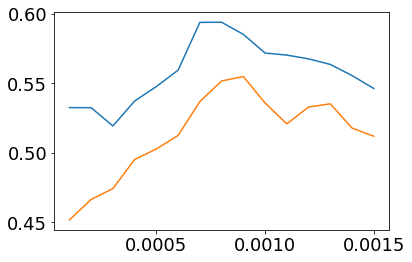

In [18]:
z_list = np.array([0.1e-3, 0.2e-3, 0.3e-3, 0.4e-3, 0.5e-3, 0.6e-3, 0.7e-3, 0.8e-3, 0.9e-3, 1.0e-3, 1.1e-3, 1.2e-3, 1.3e-3, 1.4e-3, 1.5e-3])
acc = np.array(acc_list)
plt.plot(z_list, acc[:,0])
plt.plot(z_list, acc[:,1])